<a href="https://colab.research.google.com/github/xoxonut/DL_2024_Fall/blob/main/hw2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
input_shape = (32,32,3)
num_classes = 10
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
def get_sets():
  tmp_x_train_sets = []
  tmp_y_train_sets = []
  for i in range(1,6):
    file = '/content/data_batch_'+str(i)
    data = unpickle(file)
    tmp_x_train_sets.append(
        data[b'data'].reshape(10000,3,32,32).transpose(0, 2, 3, 1))
    tmp_y_train_sets.append(data[b'labels'])
  x_train_set = np.concatenate(tmp_x_train_sets)
  y_train_set = np.concatenate(tmp_y_train_sets)
  file = '/content/test_batch'
  data = unpickle(file)
  x_test_set = data[b'data'].reshape(10000,3,32,32).transpose(0, 2, 3, 1)
  y_test_set = np.array(data[b'labels'])
  return (x_train_set,y_train_set),(x_test_set,y_test_set)

(x_train,y_train),(x_test,y_test) = get_sets()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


In [2]:

model = Sequential(
    [
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3),activation="relu",name='Conv2D_1',padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3),activation="relu",name='Conv2D_2',padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, kernel_size=(3, 3),activation="relu",name='Conv2D_3',padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax",name='Dense'),
    ]
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
class TestLossCallback(Callback):
  def __init__(self, test_data):
    super().__init__()
    self.test_data = test_data
    self.batch_size = None
  def on_train_begin(self, logs):
    self.batch_size = self.params.get('batch_size')
  def on_epoch_end(self, epoch, logs):
    _, test_accuracy = self.model.evaluate(
        self.test_data[0],
        self.test_data[1],
        batch_size=self.batch_size,
        verbose=0
        )
    logs['test_accuracy'] = test_accuracy


In [4]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0001,
    mode='min',
    verbose=1
)


In [5]:
batch_size = 128
epochs = 300
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.084,
    callbacks = [TestLossCallback((x_test, y_test)),early_stopping]
)


Epoch 1/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.2693 - loss: 1.9587 - val_accuracy: 0.5095 - val_loss: 1.3875 - test_accuracy: 0.5140
Epoch 2/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4886 - loss: 1.4177 - val_accuracy: 0.5843 - val_loss: 1.2016 - test_accuracy: 0.5724
Epoch 3/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5569 - loss: 1.2470 - val_accuracy: 0.6176 - val_loss: 1.0960 - test_accuracy: 0.6133
Epoch 4/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5896 - loss: 1.1575 - val_accuracy: 0.6738 - val_loss: 0.9881 - test_accuracy: 0.6547
Epoch 5/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6236 - loss: 1.0721 - val_accuracy: 0.6857 - val_loss: 0.9396 - test_accuracy: 0.6710
Epoch 6/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6443 - loss: 1.0214 - val_accuracy: 0.7029 - val_loss: 0.8871 - test_accuracy: 0.6894
Epoch 7/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6516 - loss

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6226005554199219
Test accuracy: 0.7922999858856201


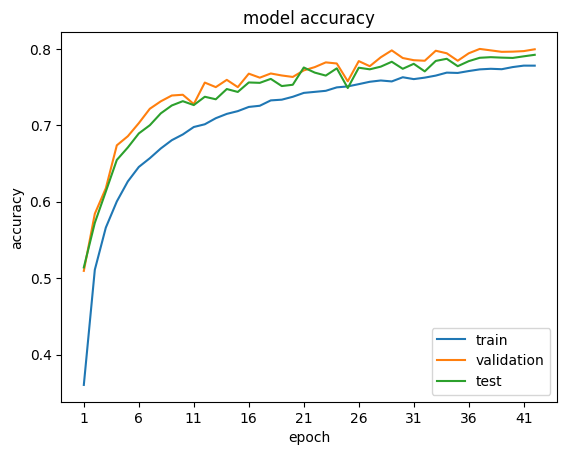

In [7]:
iterate = range(1, len(history.history['accuracy'])+1)
ticks = range(1, len(history.history['accuracy'])+1,5)
plt.xticks(ticks)
plt.plot(iterate, history.history['accuracy'],)
plt.plot(iterate, history.history['val_accuracy'])
plt.plot(iterate, history.history['test_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'])
plt.show()


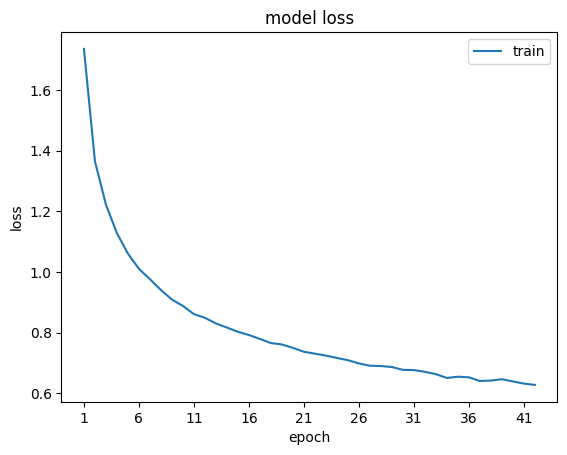

In [8]:
plt.xticks(ticks)
plt.plot(iterate, history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()


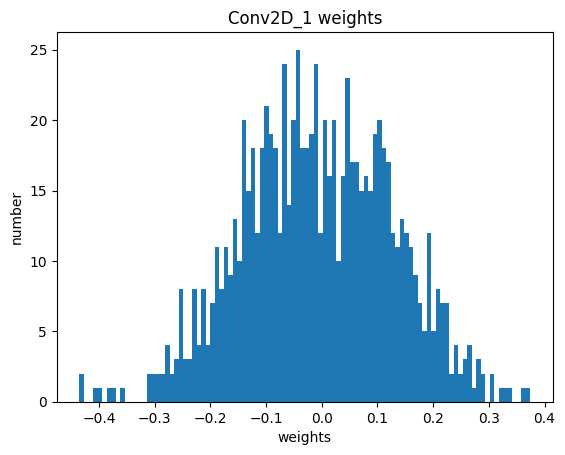

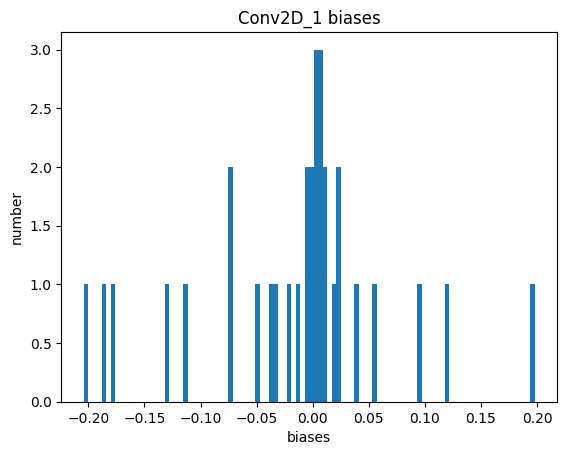

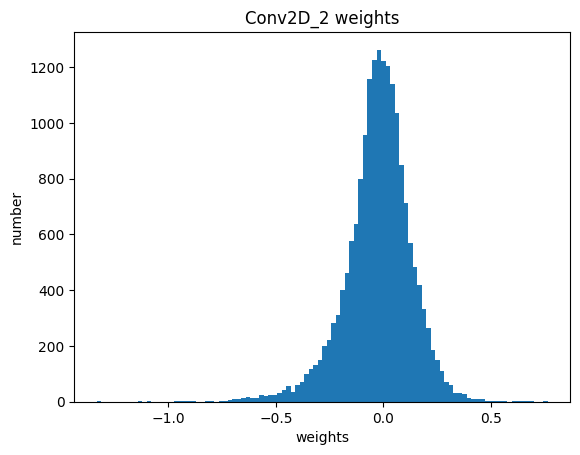

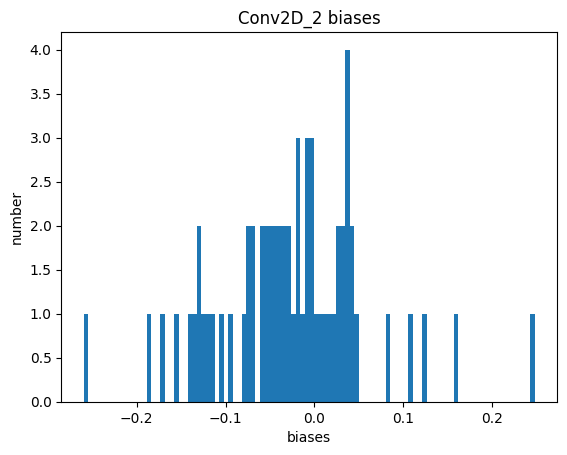

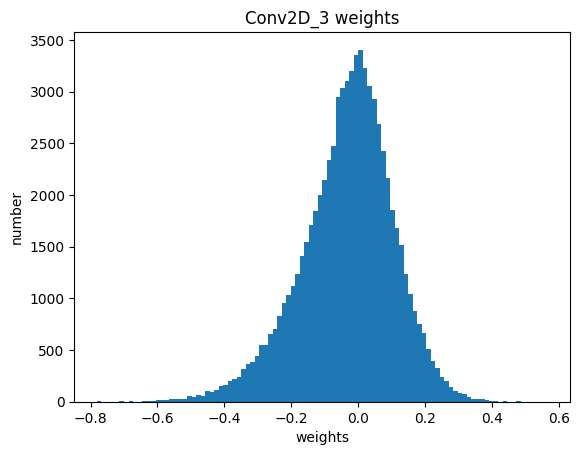

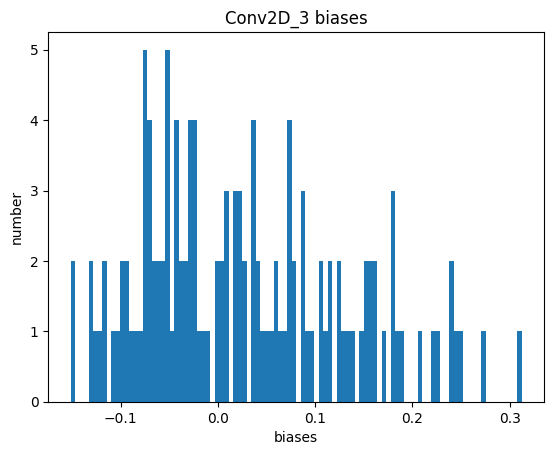

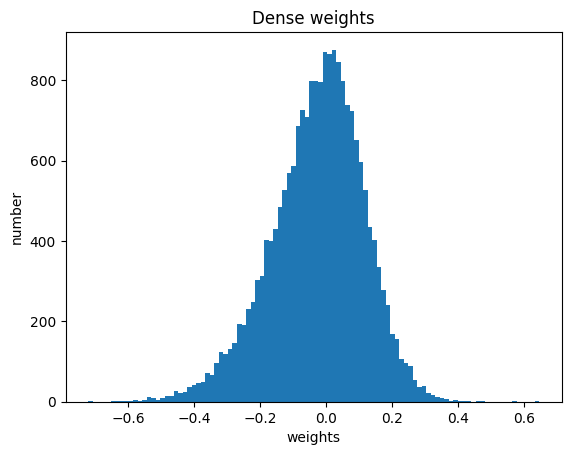

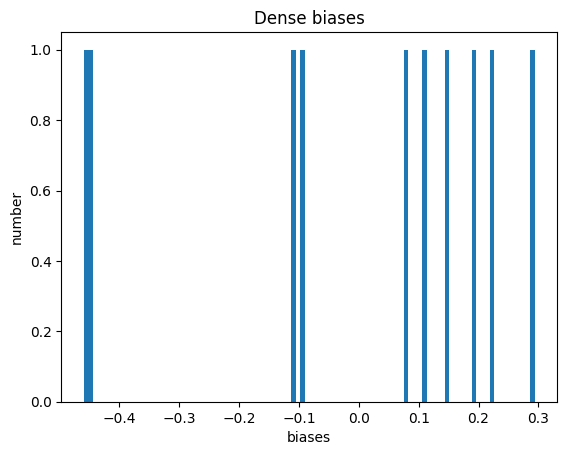

In [9]:
W = model.get_weights()
for layer in model.layers:
    w = layer.get_weights()
    if w:
      plt.hist(w[0].flatten(),bins=100)
      plt.title(f'{layer.name} weights')
      plt.xlabel('weights')
      plt.ylabel('number')
      plt.show()
      plt.hist(w[1].flatten(),bins=100)
      plt.title(f'{layer.name} biases')
      plt.xlabel('biases')
      plt.ylabel('number')
      plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Label: 3
Predict: 3


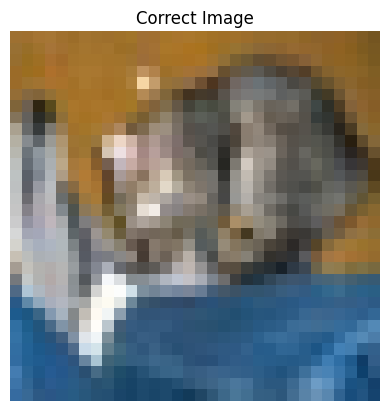

Layer 1 feature map shape: (1, 32, 32, 32)


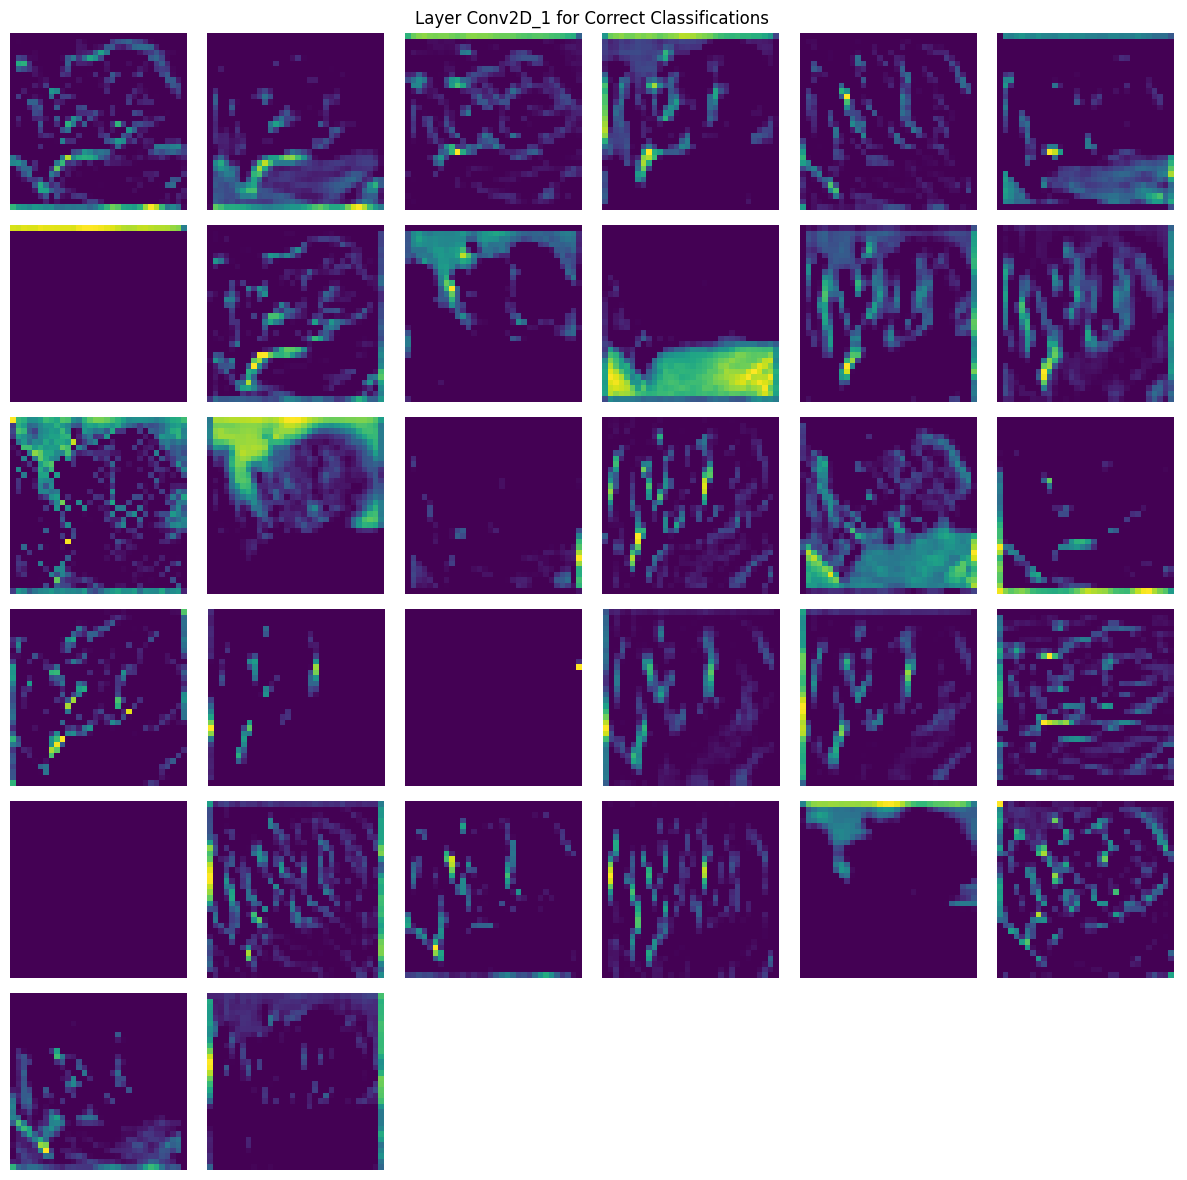

Layer 2 feature map shape: (1, 16, 16, 64)


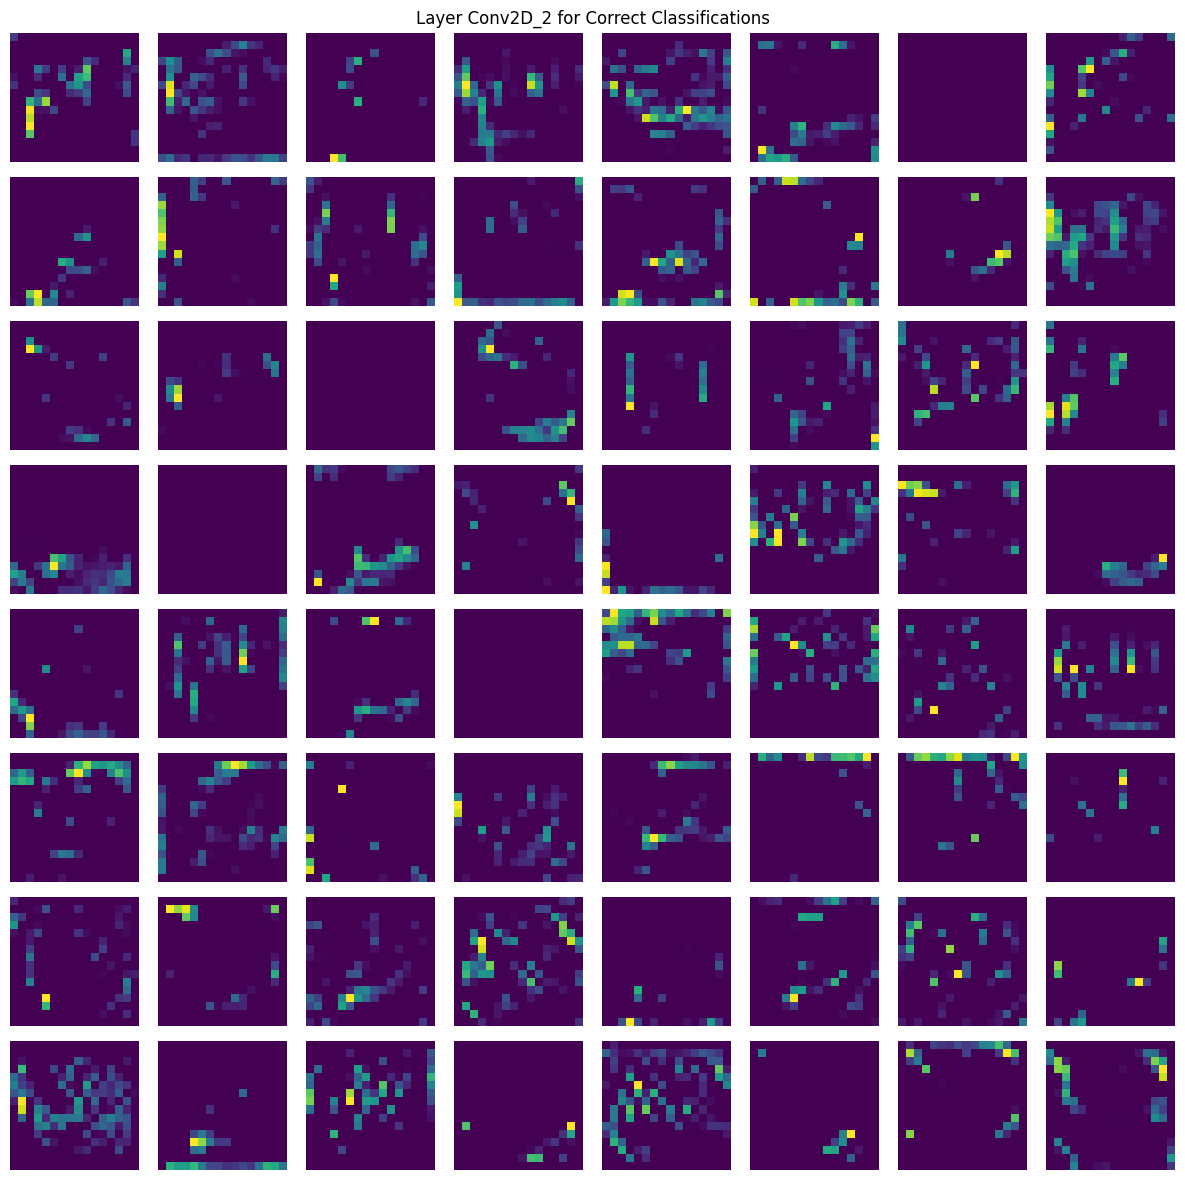

Layer 3 feature map shape: (1, 8, 8, 128)


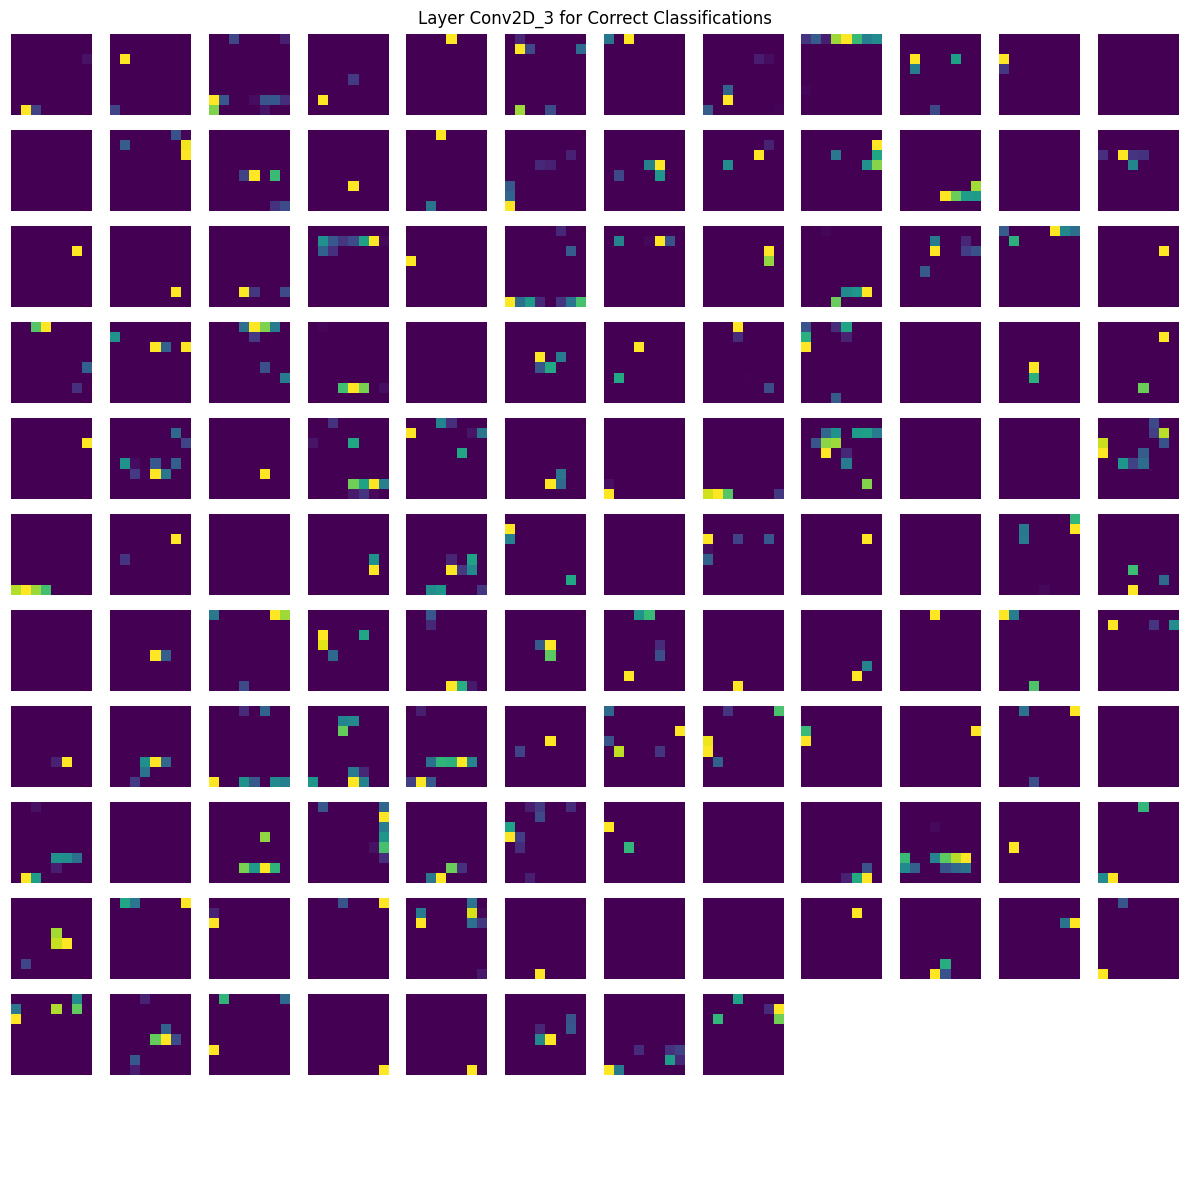

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Label: 8
Predict: 0


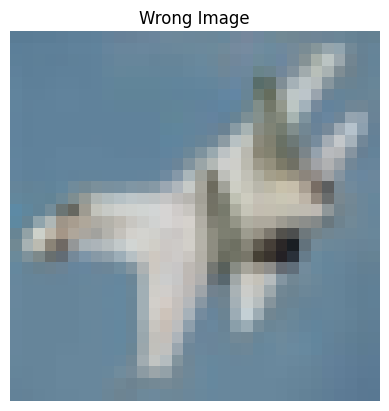

Layer 1 feature map shape: (1, 32, 32, 32)


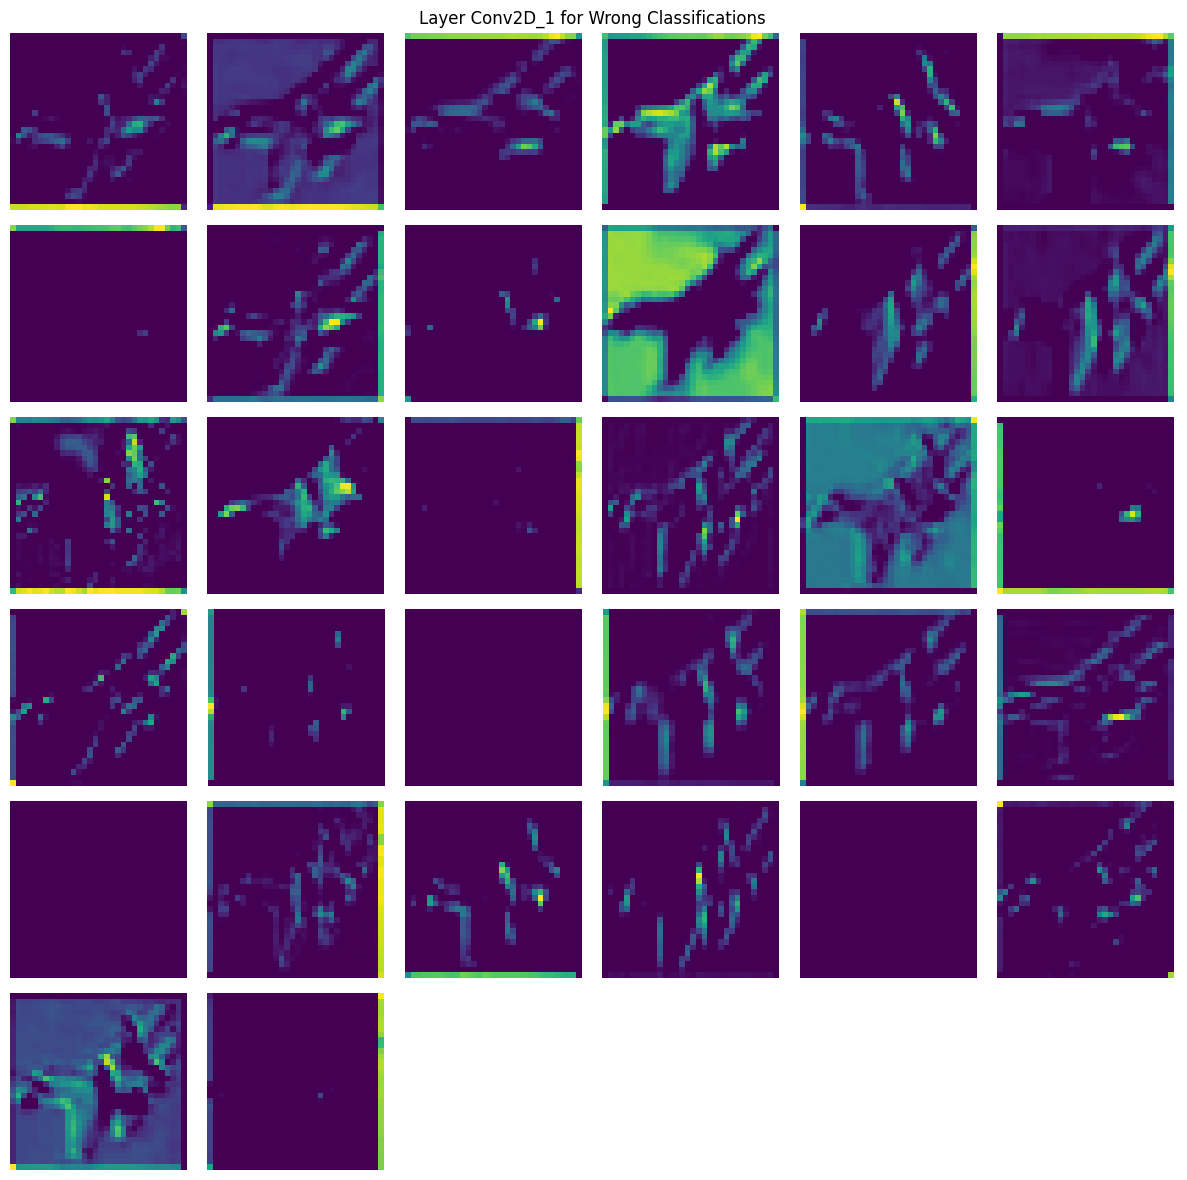

Layer 2 feature map shape: (1, 16, 16, 64)


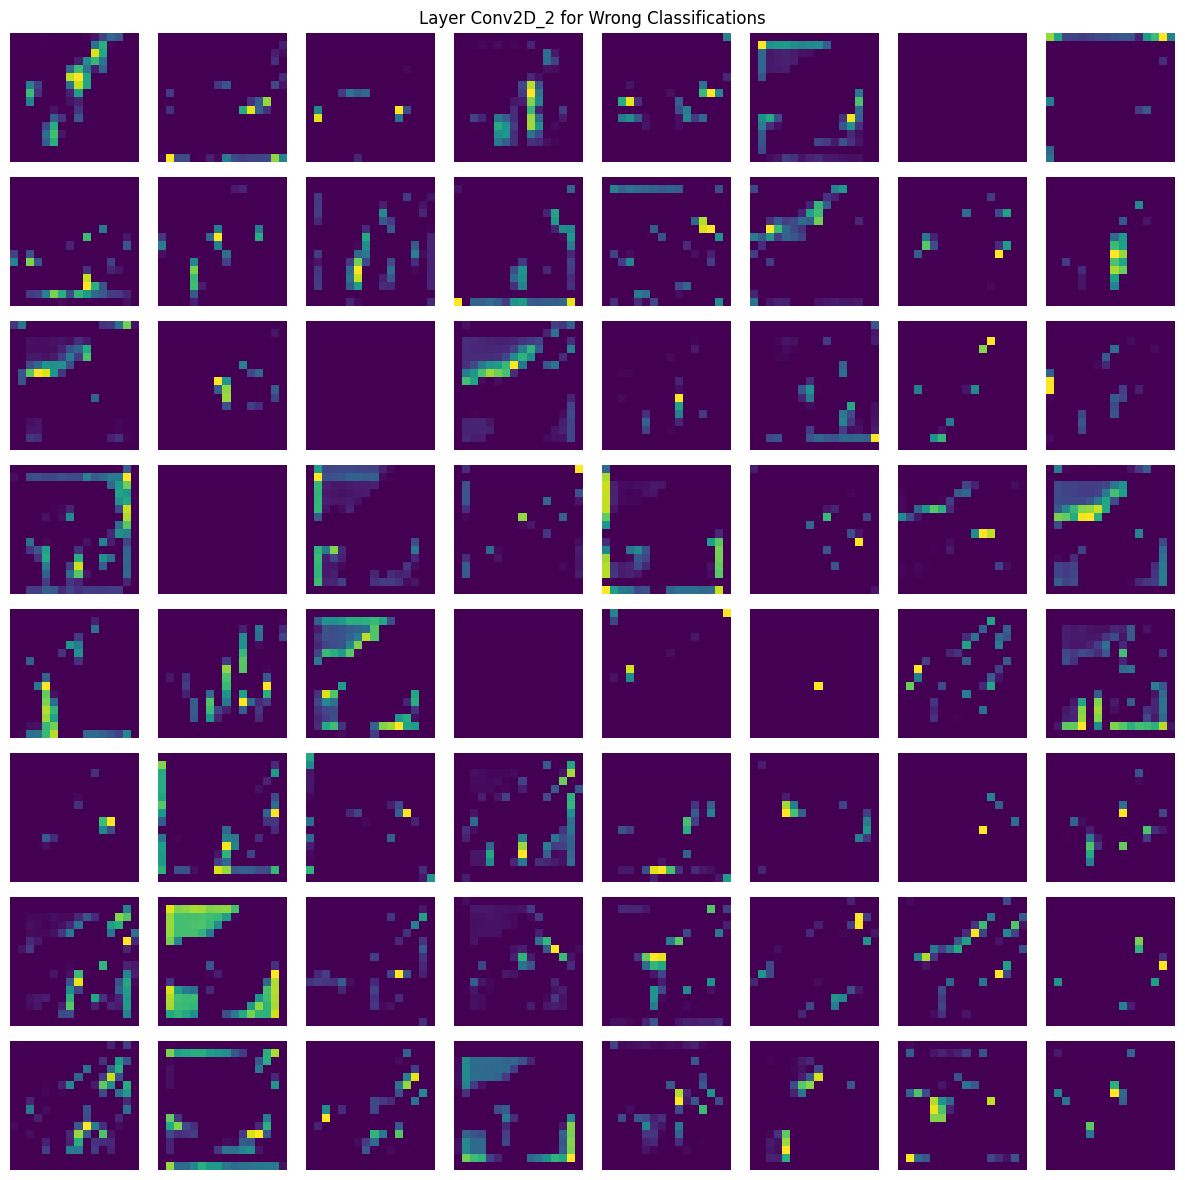

Layer 3 feature map shape: (1, 8, 8, 128)


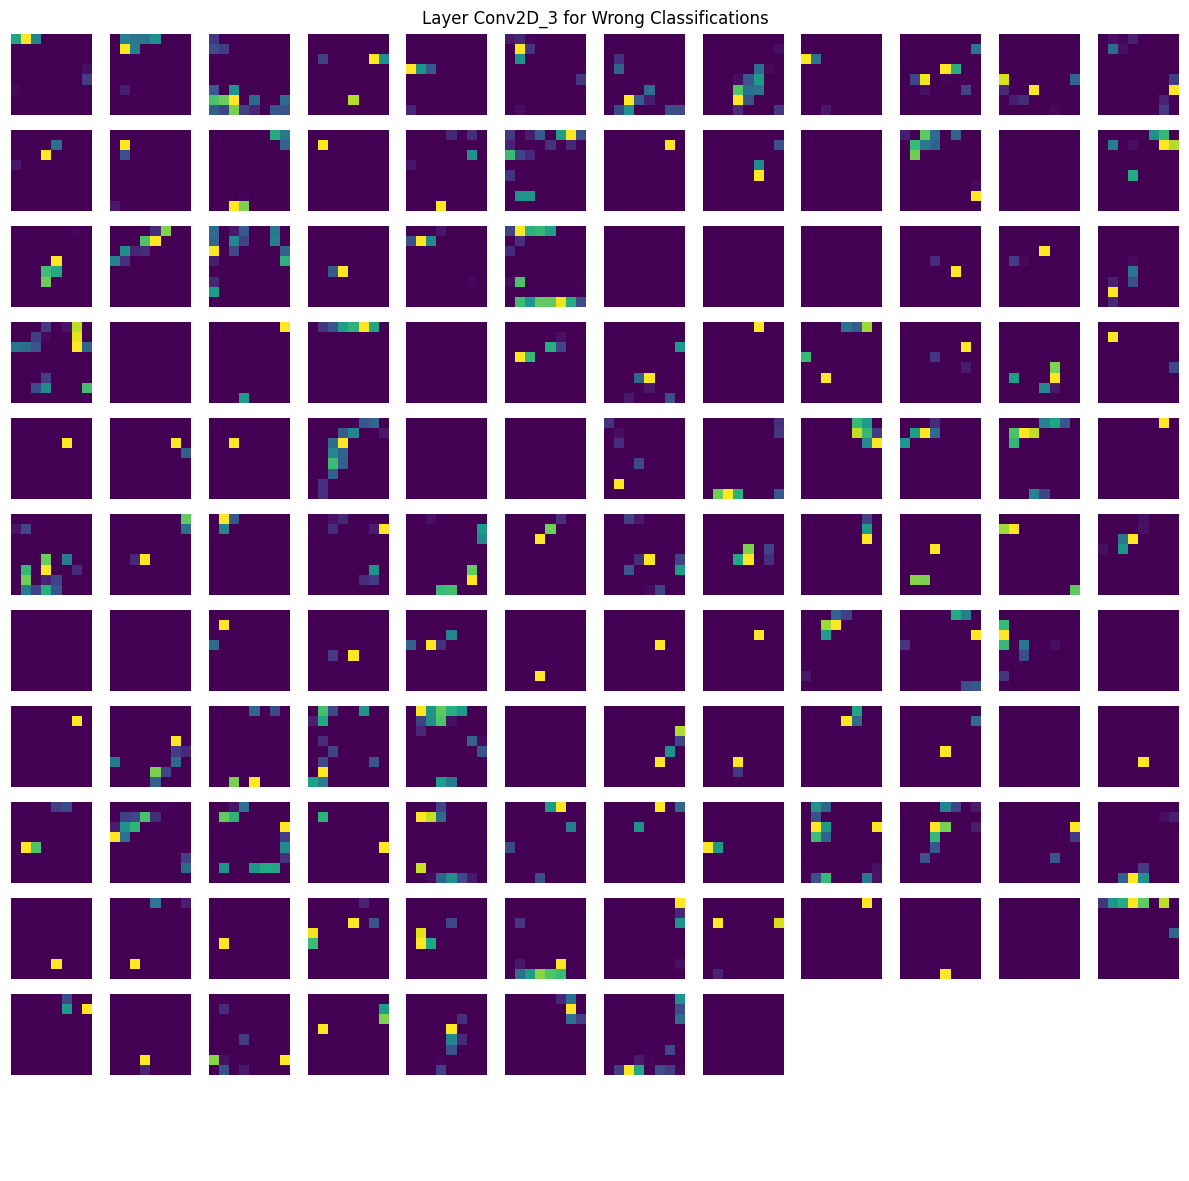

In [10]:
from math import ceil
from tensorflow.keras.models import Model
def show_feature_maps(index,title,label,predict):
  layer_outputs = [layer.output for layer in model.layers if 'Conv2D' in layer.name]
  feature_map_model = Model(inputs=model.inputs, outputs=layer_outputs)
  feature_maps = feature_map_model.predict(x_test[index].reshape(1,32,32,3))
  names = [layer.name for layer in feature_map_model.layers if 'Conv2D' in layer.name]
  print(f'Label: {label}')
  print(f'Predict: {predict}')
  # show label picture
  image = x_test[index].reshape(32,32,3)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.title(f'{title} Image')
  plt.show()
  for i, feature_map in enumerate(feature_maps):
      # number of channel
      num_channels = feature_map.shape[-1]
      # feature map size
      size = feature_map.shape[1]

      print(f"Layer {i+1} feature map shape: {feature_map.shape}")


      grid_size = ceil(num_channels ** 0.5)
      fig, ax = plt.subplots(grid_size, grid_size, figsize=(12, 12))
      fig.suptitle(f'Layer {names[i]} for {title} Classifications')

      # show picture for feature maps in one picture
      for j in range(num_channels):
          row, col = divmod(j, grid_size)
          ax[row, col].imshow(feature_map[0, :, :, j], cmap='viridis')
          ax[row, col].axis('off')
      for j in range(num_channels, grid_size**2):
          row, col = divmod(j, grid_size)
          ax[row, col].axis('off')
      plt.tight_layout()
      plt.show()

predictions = model.predict(x_test)
predictions_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
correct = np.where(predictions_labels == true_labels)[0]
wrong = np.where(predictions_labels != true_labels)[0]
show_feature_maps(correct[0],'Correct',predictions_labels[correct[0]],true_labels[correct[0]])
show_feature_maps(wrong[0],'Wrong',predictions_labels[wrong[0]],true_labels[wrong[0]])


In [11]:
from tensorflow.keras import regularizers
l2_reg = 0.01

model2 = Sequential(
    [
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3),activation="relu",name='Conv2D_1',padding='same',
               kernel_regularizer=regularizers.l2(l2_reg)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3),activation="relu",name='Conv2D_2',padding='same',
               kernel_regularizer=regularizers.l2(l2_reg)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, kernel_size=(3, 3),activation="relu",name='Conv2D_3',padding='same',
               kernel_regularizer=regularizers.l2(l2_reg)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax",name='Dense'),
    ]
)

model2.summary()
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history2 = model2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.084,
    callbacks = [TestLossCallback((x_test, y_test)),early_stopping]
)
score = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.2442 - loss: 2.4442 - val_accuracy: 0.4300 - val_loss: 1.7528 - test_accuracy: 0.4290
Epoch 2/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4084 - loss: 1.7616 - val_accuracy: 0.4650 - val_loss: 1.6369 - test_accuracy: 0.4686
Epoch 3/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4418 - loss: 1.6784 - val_accuracy: 0.4993 - val_loss: 1.5692 - test_accuracy: 0.4931
Epoch 4/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4724 - loss: 1.6063 - val_accuracy: 0.4729 - val_loss: 1.6362 - test_accuracy: 0.4734
Epoch 5/300
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4844 - loss: 1.5855 - val_accuracy: 0.5326 - val_loss: 1.4960 - test_accuracy: 0.5271
Epoch 5: early stopping
Test loss: 1.490850806236267
Test accuracy: 0.5271000266075134


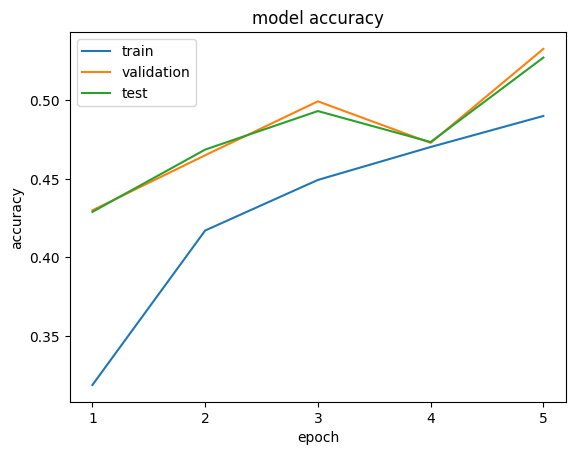

In [12]:
iterate = range(1, len(history2.history['accuracy'])+1)
ticks = range(1, len(history2.history['accuracy'])+1)
plt.xticks(ticks)
plt.plot(iterate, history2.history['accuracy'],)
plt.plot(iterate, history2.history['val_accuracy'])
plt.plot(iterate, history2.history['test_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'])
plt.show()


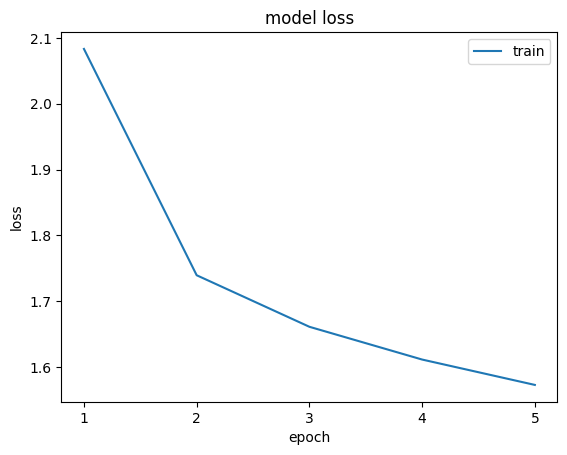

In [13]:
plt.xticks(ticks)
plt.plot(iterate, history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()


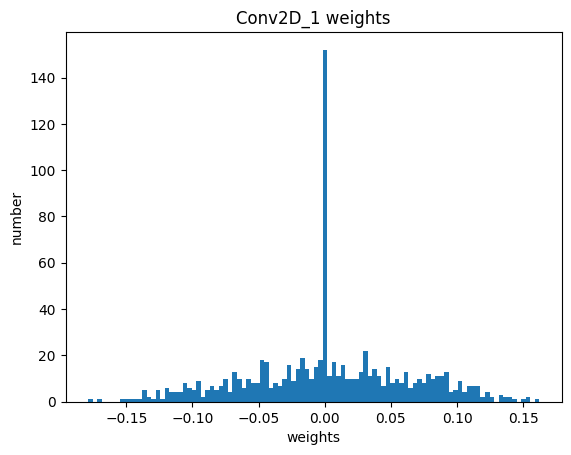

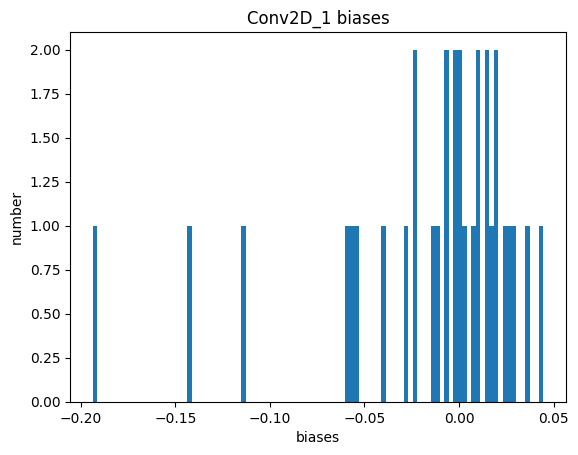

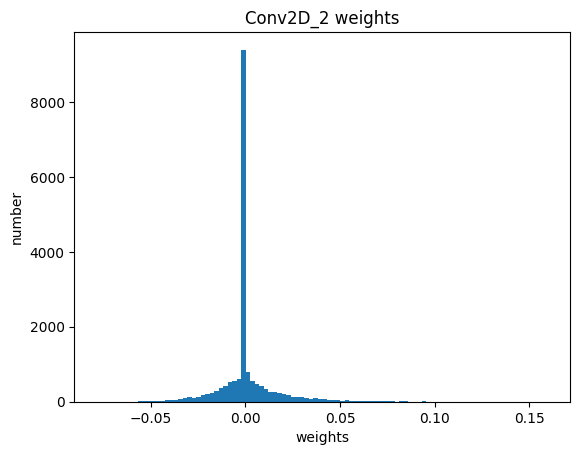

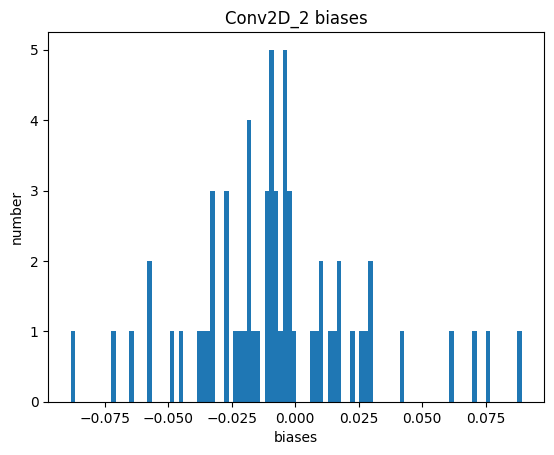

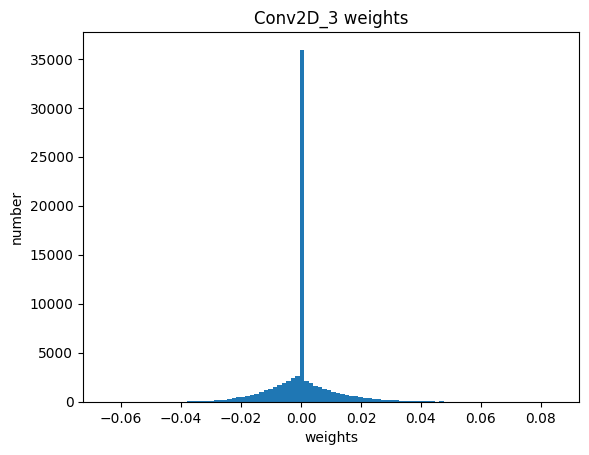

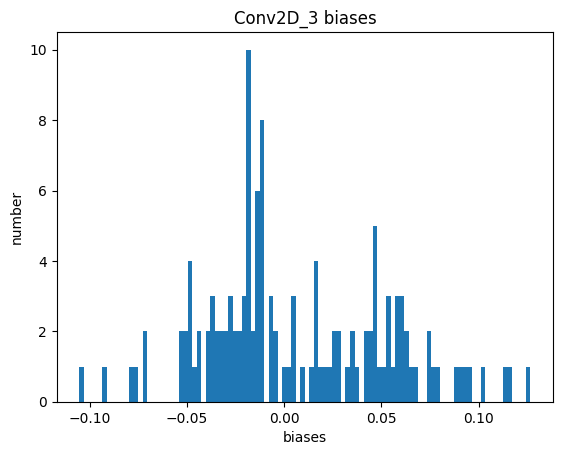

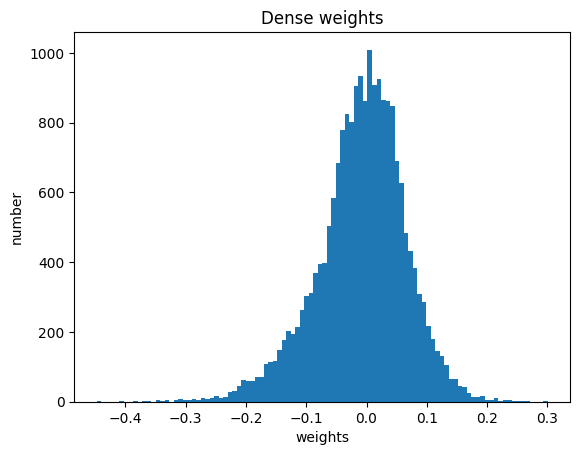

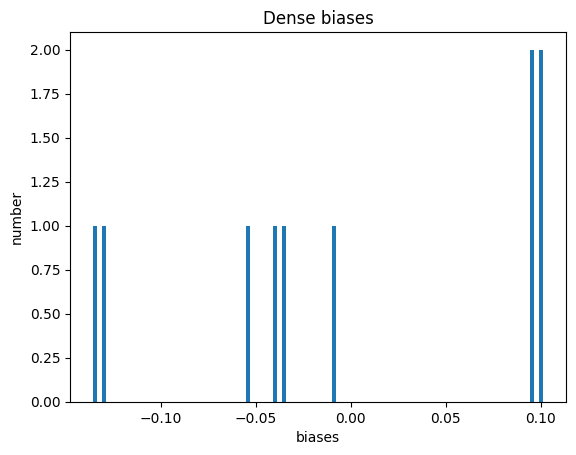

In [14]:
W = model2.get_weights()
for layer in model2.layers:
    w = layer.get_weights()
    if w:
      plt.hist(w[0].flatten(),bins=100)
      plt.title(f'{layer.name} weights')
      plt.xlabel('weights')
      plt.ylabel('number')
      plt.show()
      plt.hist(w[1].flatten(),bins=100)
      plt.title(f'{layer.name} biases')
      plt.xlabel('biases')
      plt.ylabel('number')
      plt.show()


In [15]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
a = unpickle('/content/batches.meta')
print(a)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}
